# 不同表现分段学生的Tutor辅导提升效果分析

本notebook分析不同基础表现水平的学生，在接受tutor辅导后的Task4准确率提升情况。

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from scipy import stats
import warnings
import os
warnings.filterwarnings('ignore')

# Create pictures directory in project root if it doesn't exist
pictures_dir = '../pictures'
os.makedirs(pictures_dir, exist_ok=True)

## 1. 数据加载

In [38]:
# 直接使用 pd.read_pickle 读取 DataFrame
baseline_df = pd.read_pickle('experiment_results_baseline_qwen-plus.pkl')
tutoring_df = pd.read_pickle('experiment_results_tutoring_only_qwen-plus.pkl')
print(f"数据加载完成: Baseline {baseline_df.shape}, Tutoring {tutoring_df.shape}")

数据加载完成: Baseline (16775, 16), Tutoring (16775, 18)


## 2. 计算Task指标（参考run_experiment.py）


In [39]:
def parse_answer_choice(val):
    if not isinstance(val, str): return None
    val = val.strip().upper()
    return val[0] if val and val[0] in 'ABCDEFGH' else None

def check_answer_correctness(row):
    predicted_choice = row.get('predicted_answer_choice')
    if predicted_choice is None: return None
    try:
        import ast
        choices = ast.literal_eval(row.get('question_choices'))
        choice_index = ord(predicted_choice) - ord('A')
        predicted_choice_id = choices[choice_index].get('choice_id')
        return 1 if predicted_choice_id == row.get('true_answer_choice_id') else 0
    except: return None

# 计算task4_correct
baseline_df['predicted_answer_choice'] = baseline_df['predicted_task4_answer_choice'].apply(parse_answer_choice)
baseline_df['task4_correct'] = baseline_df.apply(check_answer_correctness, axis=1)
tutoring_df['predicted_answer_choice'] = tutoring_df['predicted_task4_answer_choice'].apply(parse_answer_choice)
tutoring_df['task4_correct'] = tutoring_df.apply(check_answer_correctness, axis=1)
print("指标计算完成")


指标计算完成


## 3. 学生表现分析


In [40]:
# Calculate Task4 accuracy by student for baseline
student_baseline = baseline_df.groupby('student_id')['task4_correct'].mean().rename('baseline_accuracy')
student_tutoring = tutoring_df.groupby('student_id')['task4_correct'].mean().rename('tutoring_accuracy')
student_comparison = pd.DataFrame({'baseline_accuracy': student_baseline, 'tutoring_accuracy': student_tutoring})
student_comparison['improvement'] = student_comparison['tutoring_accuracy'] - student_comparison['baseline_accuracy']

# Segment students by quartiles
quartiles = student_comparison['baseline_accuracy'].quantile([0.25, 0.5, 0.75])
def assign_segment(acc):
    if acc <= quartiles[0.25]: return 'Q1 (Low)'
    elif acc <= quartiles[0.5]: return 'Q2 (Mid-Low)'
    elif acc <= quartiles[0.75]: return 'Q3 (Mid-High)'
    else: return 'Q4 (High)'
student_comparison['segment'] = student_comparison['baseline_accuracy'].apply(assign_segment)

# Statistics by segment
segment_stats = student_comparison.groupby('segment').agg({
    'baseline_accuracy': ['mean', 'std', 'count'],
    'tutoring_accuracy': ['mean', 'std'],
    'improvement': ['mean', 'std']
})
print(segment_stats)


              baseline_accuracy                 tutoring_accuracy            \
                           mean       std count              mean       std   
segment                                                                       
Q1 (Low)               0.702481  0.105323   328          0.770820  0.118714   
Q2 (Mid-Low)           0.815682  0.016424   256          0.830741  0.077014   
Q3 (Mid-High)          0.888760  0.025446   274          0.886682  0.067246   
Q4 (High)              0.993390  0.017635   282          0.974999  0.065639   

              improvement            
                     mean       std  
segment                              
Q1 (Low)         0.068339  0.130929  
Q2 (Mid-Low)     0.015059  0.077049  
Q3 (Mid-High)   -0.002078  0.064444  
Q4 (High)       -0.018390  0.063923  


## 4. 数据可视化


In [41]:
# Set font for better display
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# Prepare segment list
segments = ['Q1 (Low)', 'Q2 (Mid-Low)', 'Q3 (Mid-High)', 'Q4 (High)']


### 4.1 Accuracy Comparison Across Student Segments


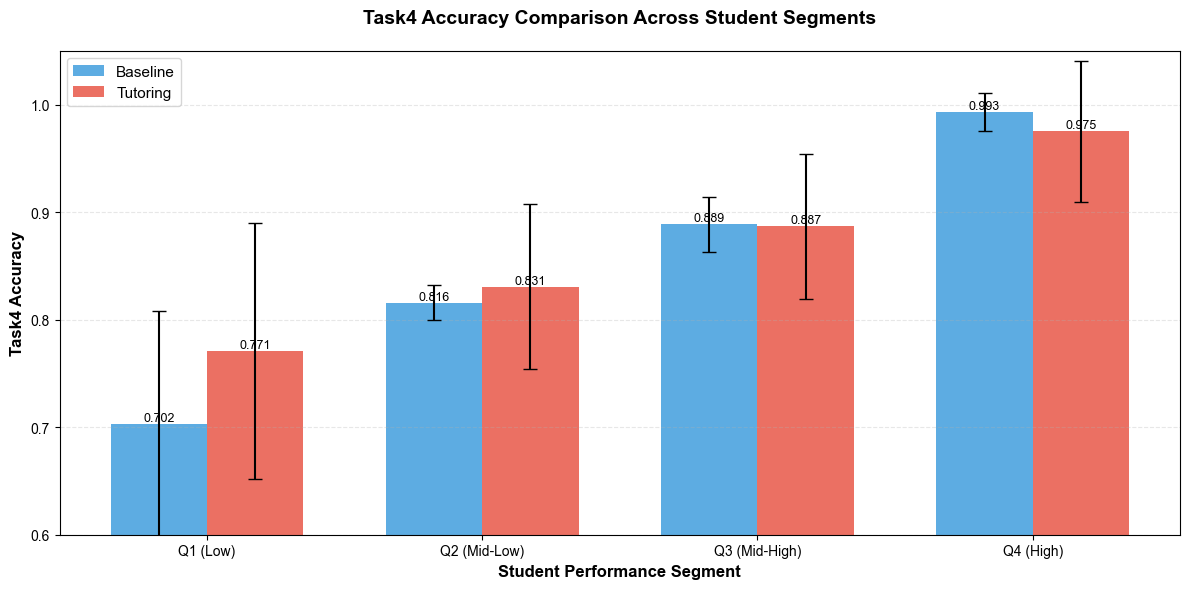

Saved: ../pictures/accuracy_comparison_by_segment.png


In [42]:
# Prepare data
baseline_means = [segment_stats.loc[seg, ('baseline_accuracy', 'mean')] for seg in segments]
tutoring_means = [segment_stats.loc[seg, ('tutoring_accuracy', 'mean')] for seg in segments]
baseline_stds = [segment_stats.loc[seg, ('baseline_accuracy', 'std')] for seg in segments]
tutoring_stds = [segment_stats.loc[seg, ('tutoring_accuracy', 'std')] for seg in segments]

# Create comparison bar chart
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(segments))
width = 0.35

bars1 = ax.bar(x - width/2, baseline_means, width, label='Baseline', 
               yerr=baseline_stds, capsize=5, alpha=0.8, color='#3498db')
bars2 = ax.bar(x + width/2, tutoring_means, width, label='Tutoring', 
               yerr=tutoring_stds, capsize=5, alpha=0.8, color='#e74c3c')

ax.set_xlabel('Student Performance Segment', fontsize=12, fontweight='bold')
ax.set_ylabel('Task4 Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Task4 Accuracy Comparison Across Student Segments', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(segments)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0.6, 1.05)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(f'{pictures_dir}/accuracy_comparison_by_segment.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {pictures_dir}/accuracy_comparison_by_segment.png")


### 4.2 Improvement Effect of Tutoring


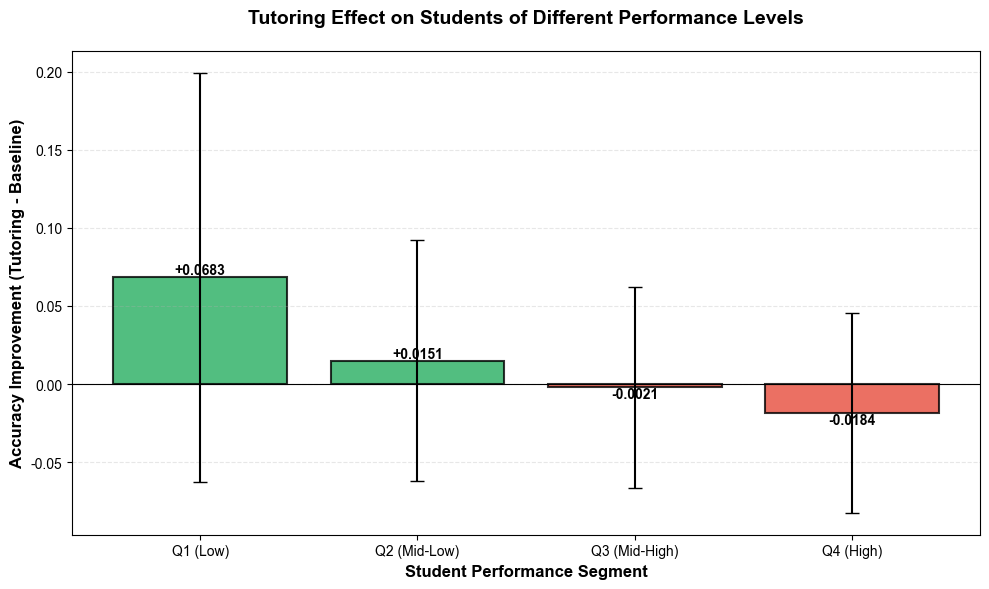

Saved: ../pictures/tutoring_improvement_effect.png


In [43]:
# Improvement magnitude bar chart
improvement_means = [segment_stats.loc[seg, ('improvement', 'mean')] for seg in segments]
improvement_stds = [segment_stats.loc[seg, ('improvement', 'std')] for seg in segments]

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#27ae60' if x > 0 else '#e74c3c' for x in improvement_means]
bars = ax.bar(segments, improvement_means, yerr=improvement_stds, 
              capsize=5, alpha=0.8, color=colors, edgecolor='black', linewidth=1.5)

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.set_xlabel('Student Performance Segment', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy Improvement (Tutoring - Baseline)', fontsize=12, fontweight='bold')
ax.set_title('Tutoring Effect on Students of Different Performance Levels', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, improvement_means)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:+.4f}', ha='center', 
            va='bottom' if height > 0 else 'top', 
            fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{pictures_dir}/tutoring_improvement_effect.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {pictures_dir}/tutoring_improvement_effect.png")


### 4.3 Individual Student Improvement Distribution


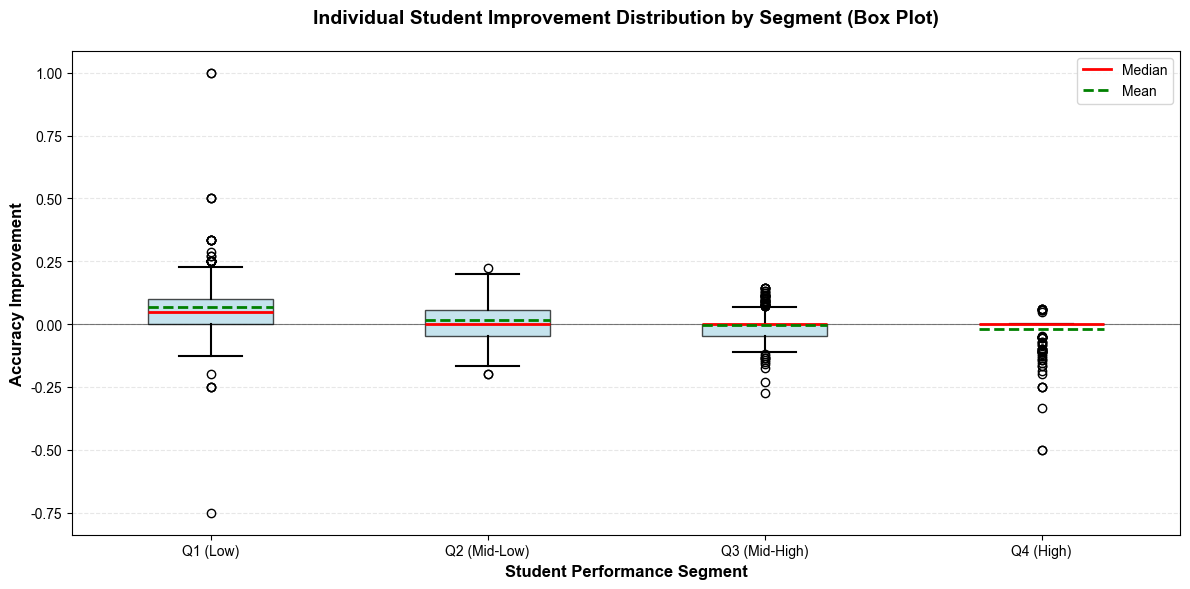

Saved: ../pictures/improvement_distribution_boxplot.png


In [44]:
# Box plot showing improvement distribution within each segment
fig, ax = plt.subplots(figsize=(12, 6))

segment_data = [student_comparison[student_comparison['segment'] == seg]['improvement'].values 
                for seg in segments]

bp = ax.boxplot(segment_data, labels=segments, patch_artist=True,
                showmeans=True, meanline=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2),
                meanprops=dict(color='green', linewidth=2, linestyle='--'),
                whiskerprops=dict(linewidth=1.5),
                capprops=dict(linewidth=1.5))

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
ax.set_xlabel('Student Performance Segment', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy Improvement', fontsize=12, fontweight='bold')
ax.set_title('Individual Student Improvement Distribution by Segment (Box Plot)', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='red', linewidth=2, label='Median'),
                   Line2D([0], [0], color='green', linewidth=2, linestyle='--', label='Mean')]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig(f'{pictures_dir}/improvement_distribution_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {pictures_dir}/improvement_distribution_boxplot.png")


### 4.4 Scatter Plot: Baseline vs Tutoring Accuracy

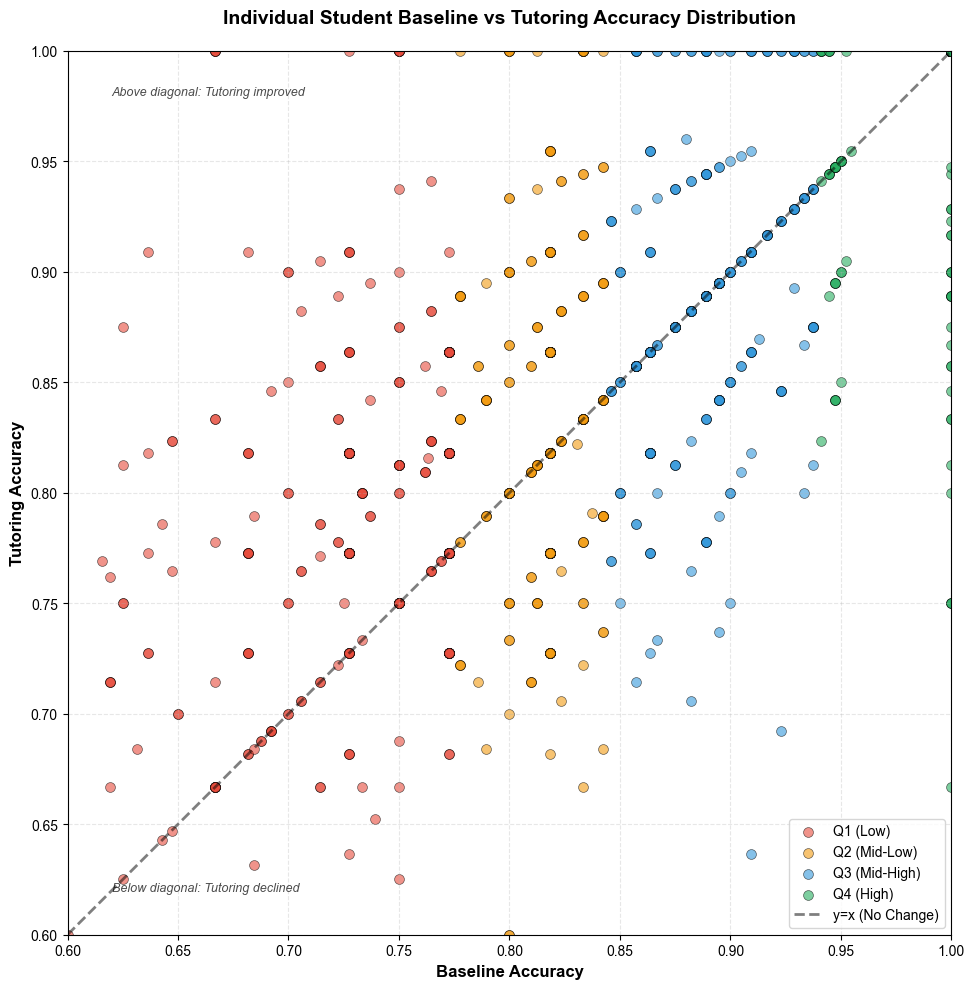

Saved: ../pictures/baseline_vs_tutoring_scatter.png


In [45]:
# Scatter plot showing baseline and tutoring accuracy for each student
fig, ax = plt.subplots(figsize=(10, 10))

colors_map = {'Q1 (Low)': '#e74c3c', 'Q2 (Mid-Low)': '#f39c12', 
              'Q3 (Mid-High)': '#3498db', 'Q4 (High)': '#27ae60'}

for segment in segments:
    data = student_comparison[student_comparison['segment'] == segment]
    ax.scatter(data['baseline_accuracy'], data['tutoring_accuracy'], 
               alpha=0.6, s=50, c=colors_map[segment], label=segment, edgecolors='black', linewidth=0.5)

# Add diagonal line (y=x)
ax.plot([0.6, 1.0], [0.6, 1.0], 'k--', alpha=0.5, linewidth=2, label='y=x (No Change)')

ax.set_xlabel('Baseline Accuracy', fontsize=12, fontweight='bold')
ax.set_ylabel('Tutoring Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Individual Student Baseline vs Tutoring Accuracy Distribution', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3, linestyle='--')
ax.set_xlim(0.6, 1.0)
ax.set_ylim(0.6, 1.0)
ax.set_aspect('equal')

# Add text annotations
ax.text(0.62, 0.98, 'Above diagonal: Tutoring improved', fontsize=9, style='italic', alpha=0.7)
ax.text(0.62, 0.62, 'Below diagonal: Tutoring declined', fontsize=9, style='italic', alpha=0.7)

plt.tight_layout()
plt.savefig(f'{pictures_dir}/baseline_vs_tutoring_scatter.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {pictures_dir}/baseline_vs_tutoring_scatter.png")

### 4.5 Improvement Effect Statistics

In [46]:
# Calculate proportion of students who improved, unchanged, or declined in each segment
improvement_summary = []
for segment in segments:
    data = student_comparison[student_comparison['segment'] == segment]
    total = len(data)
    improved = len(data[data['improvement'] > 0])
    unchanged = len(data[data['improvement'] == 0])
    declined = len(data[data['improvement'] < 0])
    
    improvement_summary.append({
        'Segment': segment,
        'Total': total,
        'Improved': improved,
        'Improved%': f'{improved/total*100:.1f}%',
        'Unchanged': unchanged,
        'Unchanged%': f'{unchanged/total*100:.1f}%',
        'Declined': declined,
        'Declined%': f'{declined/total*100:.1f}%',
        'Avg_Improvement': f'{data["improvement"].mean():.4f}'
    })

improvement_df = pd.DataFrame(improvement_summary)
print("\nTutoring Effect Statistics by Student Segment:")
print(improvement_df.to_string(index=False))


Tutoring Effect Statistics by Student Segment:
      Segment  Total  Improved Improved%  Unchanged Unchanged%  Declined Declined% Avg_Improvement
     Q1 (Low)    328       207     63.1%         88      26.8%        33     10.1%          0.0683
 Q2 (Mid-Low)    256       109     42.6%         65      25.4%        82     32.0%          0.0151
Q3 (Mid-High)    274        67     24.5%        128      46.7%        79     28.8%         -0.0021
    Q4 (High)    282         8      2.8%        233      82.6%        41     14.5%         -0.0184


### 4.6 Stacked Bar Chart: Improvement/Decline Proportions


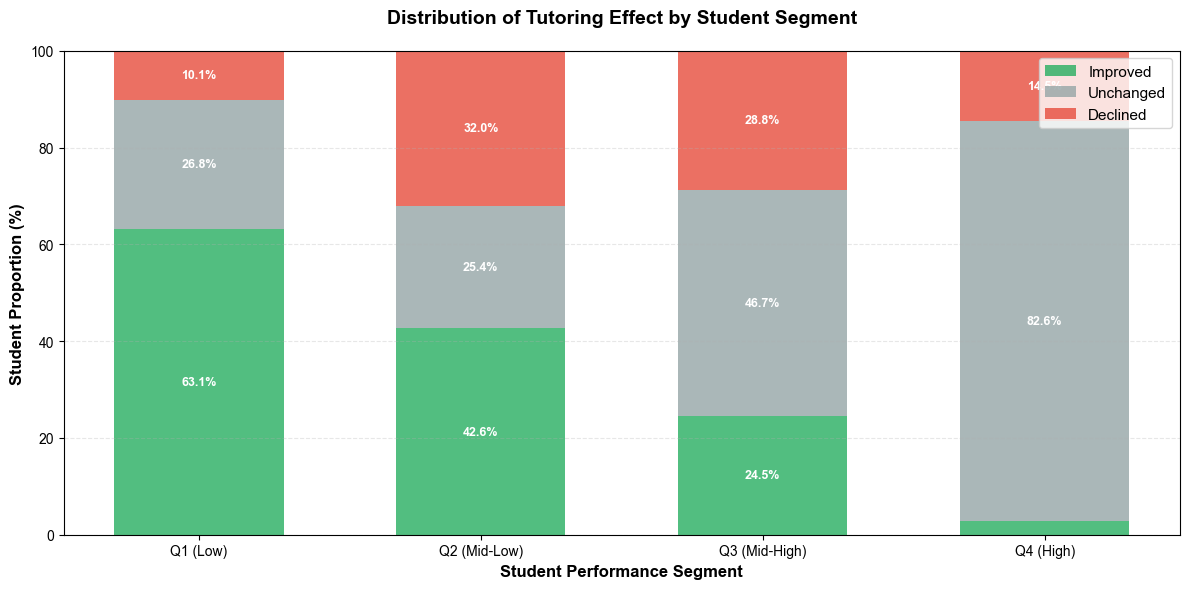

Saved: ../pictures/tutoring_effect_stacked_bar.png


In [47]:
# Stacked bar chart showing improvement/unchanged/decline proportions
fig, ax = plt.subplots(figsize=(12, 6))

improved_pct = [float(row['Improved%'].strip('%')) for row in improvement_summary]
unchanged_pct = [float(row['Unchanged%'].strip('%')) for row in improvement_summary]
declined_pct = [float(row['Declined%'].strip('%')) for row in improvement_summary]

x = np.arange(len(segments))
width = 0.6

p1 = ax.bar(x, improved_pct, width, label='Improved', color='#27ae60', alpha=0.8)
p2 = ax.bar(x, unchanged_pct, width, bottom=improved_pct, label='Unchanged', color='#95a5a6', alpha=0.8)
p3 = ax.bar(x, declined_pct, width, bottom=np.array(improved_pct)+np.array(unchanged_pct), 
            label='Declined', color='#e74c3c', alpha=0.8)

ax.set_xlabel('Student Performance Segment', fontsize=12, fontweight='bold')
ax.set_ylabel('Student Proportion (%)', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Tutoring Effect by Student Segment', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(segments)
ax.legend(loc='upper right', fontsize=11)
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add percentage labels
for i in range(len(segments)):
    # Improved
    if improved_pct[i] > 5:
        ax.text(i, improved_pct[i]/2, f'{improved_pct[i]:.1f}%', 
                ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    # Unchanged
    if unchanged_pct[i] > 5:
        ax.text(i, improved_pct[i] + unchanged_pct[i]/2, f'{unchanged_pct[i]:.1f}%', 
                ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    # Declined
    if declined_pct[i] > 5:
        ax.text(i, improved_pct[i] + unchanged_pct[i] + declined_pct[i]/2, f'{declined_pct[i]:.1f}%', 
                ha='center', va='center', fontsize=9, fontweight='bold', color='white')

plt.tight_layout()
plt.savefig(f'{pictures_dir}/tutoring_effect_stacked_bar.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {pictures_dir}/tutoring_effect_stacked_bar.png")
